In [1]:
import logging, os

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_rows = 28
img_cols = 28
channels =1

img_shape = (img_rows,img_cols,channels)
z_dim =100
num_classes = 10

In [3]:
class generator(tf.keras.Model):
    def __init__(self,z_dim):
        super(generator,self).__init__()
        self.dense1 = tf.keras.layers.Dense(7*7*256,input_dim=(100,))
        self.reshape = tf.keras.layers.Reshape((7,7,256))
        
        self.conv1 = tf.keras.layers.Conv2DTranspose(128,kernel_size=3,strides=2,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2DTranspose(64,kernel_size=3,strides=1,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.conv3 = tf.keras.layers.Conv2DTranspose(1,kernel_size=3,strides=2,padding='same')
    
    def call(self, input_tensor, training =False):
        x = self.dense1(input_tensor)
        x = self.reshape(x)
        
        x = self.conv1(x)
        x = self.bn1(x, training = training)
        x = tf.nn.leaky_relu(x, alpha=0.01)
        
        x = self.conv2(x)
        x = self.bn2(x, training = training)
        x = tf.nn.leaky_relu(x, alpha=0.01)
        
        x = self.conv3(x)
        x = tf.nn.tanh(x)
        return x        

In [4]:
class discriminator(tf.keras.Model):
    def __init__(self,img_shape):
        super(discriminator,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64,kernel_size=3,strides=2,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(64,kernel_size=3,strides=2,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(128,kernel_size=3,strides=2,padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.global_avg = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(1)
        
    def call(self, input_tensor, training =False):
        x = self.conv1(input_tensor)
#         x = self.bn1(x, training = training)
        x = tf.nn.leaky_relu(x, alpha=0.01)

        x = self.conv2(x)
#         x = self.bn2(x, training = training)
        x = tf.nn.leaky_relu(x, alpha=0.01)

        x = self.conv3(x)
#         x = self.bn3(x, training = training)
        x = tf.nn.leaky_relu(x, alpha=0.01)
        
        x = self.global_avg(x)
        x = self.fc1(x)
        x = tf.nn.sigmoid(x)
        return x      

In [5]:
g = generator(z_dim)
d = discriminator(img_shape)

In [6]:
def gen_preprocessing(z_noise, labels):
    y = tf.keras.layers.Embedding(num_classes, z_dim, input_length=1)(labels)
    y = tf.keras.layers.Flatten()(y)
    x = tf.keras.layers.Multiply()([z_noise,labels])
    return x
    
def disc_preprocessing(img, labels):
    y = tf.keras.layers.Embedding(num_classes, np.prod(img_shape), input_length=1)(labels)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Reshape(img_shape)(y)
    x = tf.keras.layers.Concatenate(axis=-1)([img,y])
    return x


In [7]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output),fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output),real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output),fake_output)
    return 0.5 * (real_loss + fake_loss)

In [8]:
def sample_images(generator, image_grid_rows=2, image_grid_cols=5):
    z = np.random.uniform(-1, 1, (image_grid_rows * image_grid_cols, z_dim))
    y = np.arange(0, 10).reshape(-1,1)
    y = y.astype('float32')
    z = gen_preprocessing(z,y)
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_cols, figsize=(10,4),sharey=True, sharex=True)

    cnt =0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].axis('off')
            axs[i,j].set_title(f'Digits : {i*5+j}')
            cnt+=1

iteration : 1000 G loss = 0.60584950 D loss = 0.57530677
iteration : 2000 G loss = 0.65414310 D loss = 0.54208112
iteration : 3000 G loss = 0.64672381 D loss = 0.54373926
iteration : 4000 G loss = 0.62518471 D loss = 0.56918168
iteration : 5000 G loss = 0.65168768 D loss = 0.56379128
iteration : 6000 G loss = 0.61401820 D loss = 0.61134565
iteration : 7000 G loss = 0.61443067 D loss = 0.60351741
iteration : 8000 G loss = 0.55012757 D loss = 0.63966596
iteration : 9000 G loss = 0.58906007 D loss = 0.63573325
iteration : 10000 G loss = 0.57147962 D loss = 0.65819132
iteration : 11000 G loss = 0.57064009 D loss = 0.65260124
iteration : 12000 G loss = 0.58836591 D loss = 0.64183986
iteration : 13000 G loss = 0.59701908 D loss = 0.63239044
iteration : 14000 G loss = 0.58607733 D loss = 0.65789866
iteration : 15000 G loss = 0.61275399 D loss = 0.64543802
iteration : 16000 G loss = 0.58590817 D loss = 0.66037607
iteration : 17000 G loss = 0.60556746 D loss = 0.65029436
iteration : 18000 G los

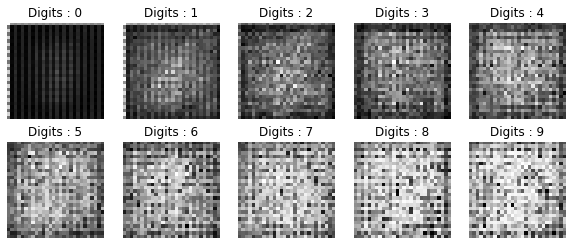

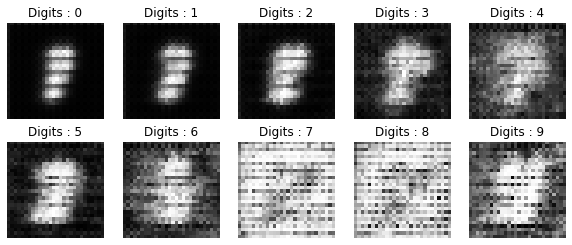

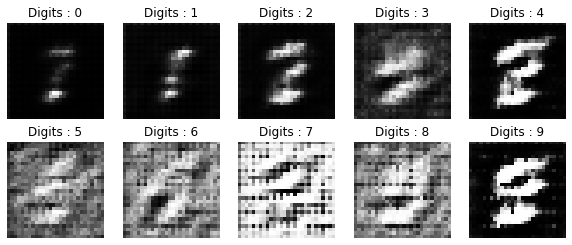

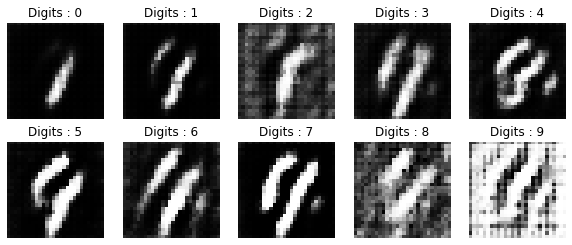

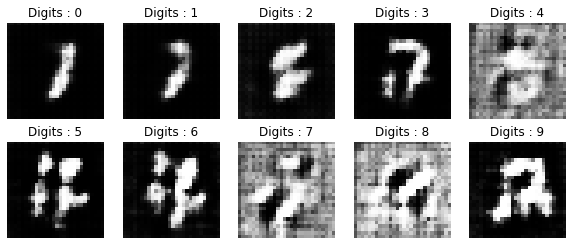

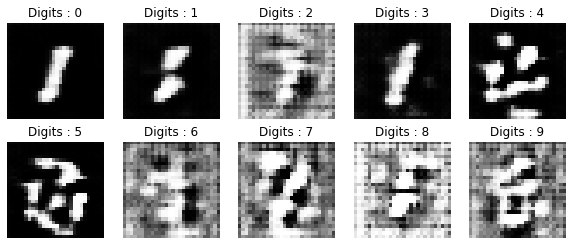

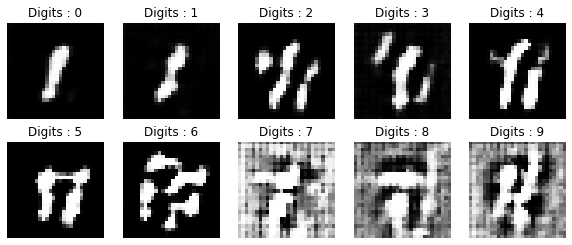

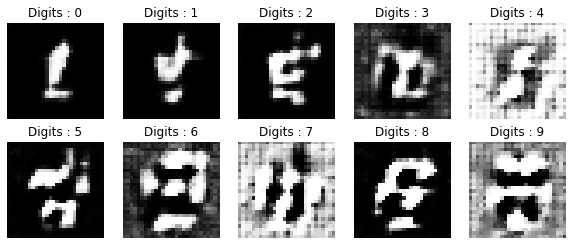

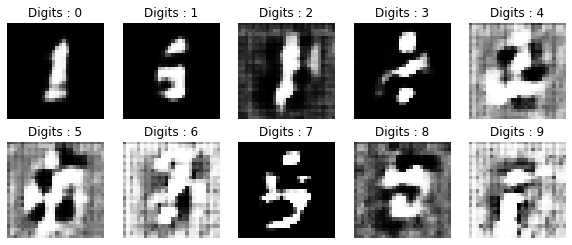

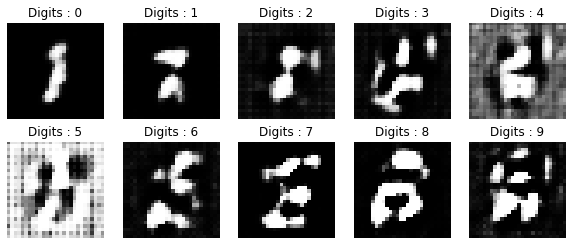

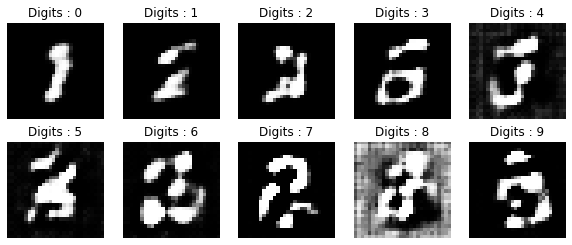

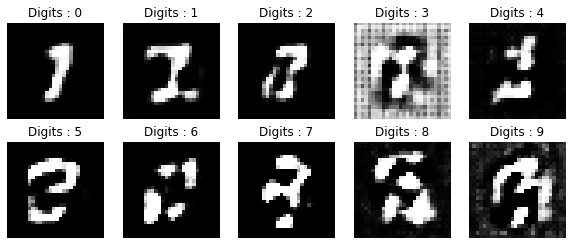

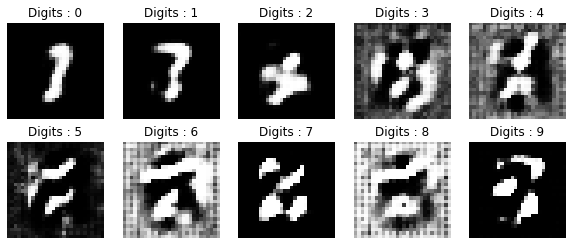

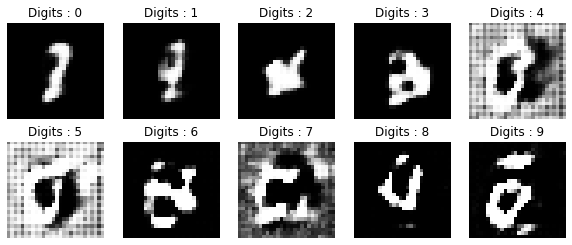

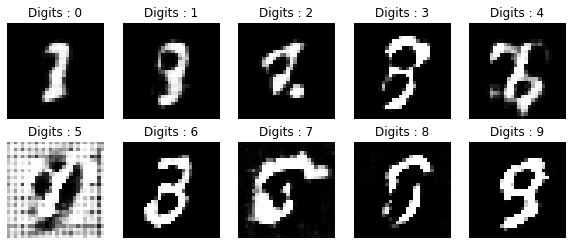

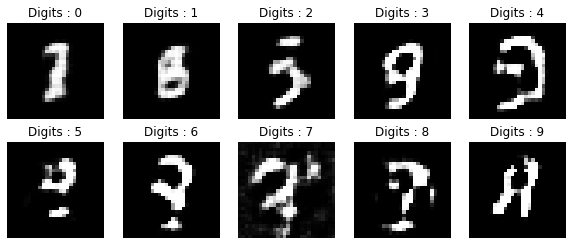

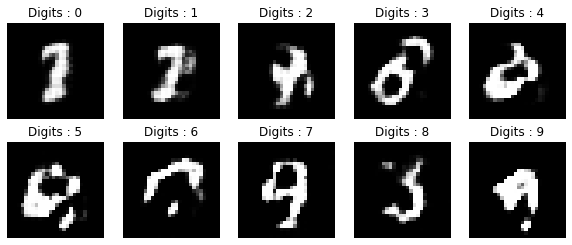

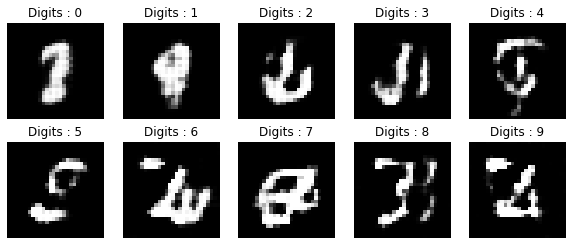

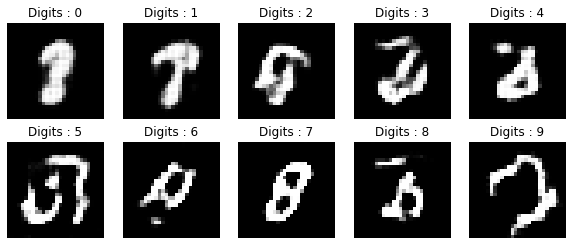

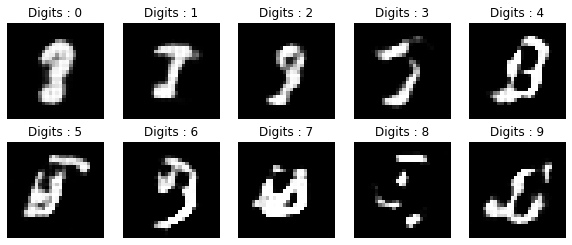

In [9]:
def train(iterations, batch_size, sample_interval):
    (x_train, y_train),(_,_) = tf.keras.datasets.mnist.load_data()
    
    x_train = x_train / 127.5 - 1.0
    x_train = x_train[...,tf.newaxis]

    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    
    real  = np.ones((batch_size, 1))
    fake  = np.zeros((batch_size, 1))

    for iteration in range(1, iterations+1):
        total_d_loss = 0.0
        total_g_loss = 0.0

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]
            labels = y_train[idx]
            
            imgs = tf.convert_to_tensor(imgs, dtype=tf.float32)
            labels = tf.convert_to_tensor(labels, dtype=tf.float32)
            
            z = np.random.uniform(-1, 1, (batch_size,100))
            
            
            imgs = disc_preprocessing(imgs,labels)
            real_output = d(imgs, training=True)
            
            z = gen_preprocessing(z,labels)
            generated_img = g(z, training=True)
            generated_img = disc_preprocessing(generated_img,labels)
            fake_output = d(generated_img, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gen_gradient = gen_tape.gradient(gen_loss, g.trainable_variables)
        disc_gradient = disc_tape.gradient(disc_loss, d.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_gradient, g.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradient, d.trainable_variables))

        if iteration % sample_interval == 0:
            print(f'iteration : {iteration} G loss = {gen_loss:.8f} D loss = {disc_loss:.8f}')
            sample_images(g)
train(20000, 32, 1000)